## Train Machine Learning Model

In [1]:
# Loading libs
from astropy.io import fits #need to install the "astropy" package
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import os
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import cv2
import copy
from astro_package import plot_array_img as pai
from astro_package import load_astro_img as load_img
from astro_package import crop_img
from astro_package import evaluations

# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
gpus = tf.config.list_physical_devices(device_type='GPU')
print(gpus)

In [3]:
disk_class = load_img.AstroImgs('./target_goal/')
ref_class = load_img.AstroImgs('./refs/')

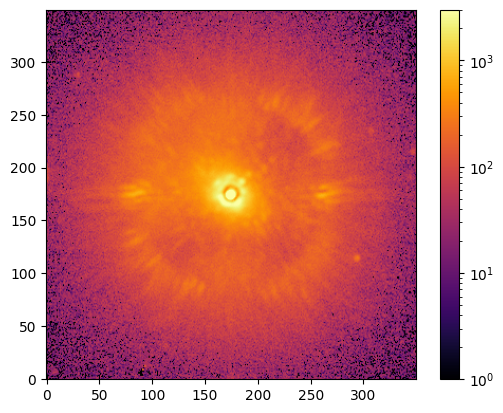

In [4]:
disk_imgs = np.array(disk_class.GetImg(), copy=True)
ref_imgs = np.array(ref_class.GetImg(), copy=True)
# pai.PlotLogImg(disk_imgs[0])
pai.PlotLogImg(ref_imgs[0])

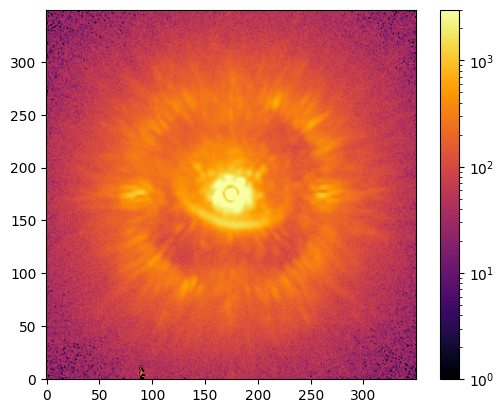

In [5]:
pai.PlotLogImg(disk_imgs[0])

(320, 320)


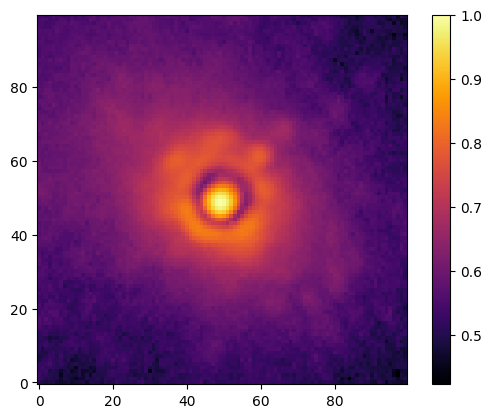

In [6]:
data = np.array((ref_imgs[0])[15:335, 15:335], copy=True)
print(data.shape)
target = data[110:210, 110:210]
target[target <= 1] = 1
log_target = np.log2(target)
norm_target = log_target/np.max(log_target)
pai.PlotLinearImg(norm_target)

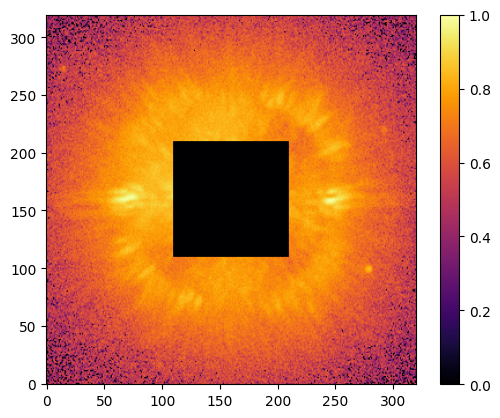

In [7]:
input_data = np.array((ref_imgs[0])[15:335, 15:335], copy=True)
input_data[110:210, 110:210] = 1
input_data[input_data <= 1] = 1
log_input = np.log2(input_data)
norm_input = log_input/np.max(log_input)
pai.PlotLinearImg(norm_input)

In [8]:
ref_class.GetImgNames()

['10PSF_HD_313493.fits',
 '11PSF_HD_313493.fits',
 '12PSF_TYC_1279-203-1.fits',
 '13PSF_BD-10_1143.fits',
 '14PSF_TYC_1279-203-1.fits',
 '15PSF_2MASS_J03471855+3152187.fits',
 '16PSF_GSC_01270-01088.fits',
 '17PSF_HD_244395.fits',
 '18PSF_HD_290737.fits',
 '19PSF_HD_101869.fits',
 '1PSF_HD_135985.fits',
 '20PSF_HD_290737.fits',
 '21PSF_HD_244395.fits',
 '22PSF_HD_290737.fits',
 '23PSF_BD-10_1143.fits',
 '24PSF_HD_244395.fits',
 '25PSF_BD-10_1143.fits',
 '26PSF_UCAC2_589393.fits',
 '27PSF_UCAC2_589393.fits',
 '28PSF_TYC_1865-648-1.fits',
 '29PSF_2MASS_J11044460-7706240.fits',
 '2PSF_BD-21_4234.fits',
 '30PSF_2MASS_J04551015+3021333.fits',
 '31PSF_CD-76_498.fits',
 '32PSF_UCAC4_570-011400.fits',
 '33PSF_GSC_01833-00780.fits',
 '34PSF_SSVS_1321.fits',
 '35PSF_2MASS_J04170622+2802326.fits',
 '36PSF_JH_33.fits',
 '37PSF_UCAC4_570-011400.fits',
 '38PSF_HD_282758.fits',
 '39PSF_2MASS_J04170622+2802326.fits',
 '3PSF_BD-21_4234.fits',
 '40PSF_2MASS_J04284090+2655414.fits',
 '41PSF_UCAC4_600-015

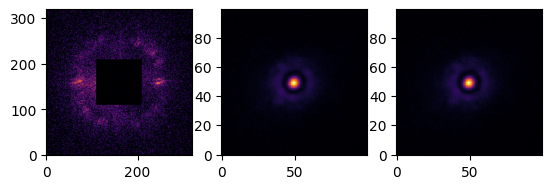

In [18]:
x_set = []
y_set = []
# for x in disk_class.GetImg():
#     data = x[125:225, 125:225]
#     data[data <= 1] = 1
#     log_data = np.ceil(np.log2(data))
#     norm_data = log_data/np.max(log_data)
#     x_set.append(norm_data)
#     y_set.append(1)
fig, axs = plt.subplots(1, 3)
count = 0
for x in ref_class.GetImg():
    data = np.array(x[15:335, 15:335], copy=True)
    count += 1
    data[data <= 1] = 1
    data = np.log2(data)
    # norm_data = data/np.max(data)
    target = norm_data[110:210, 110:210].reshape(10000)
    y_set.append(np.array(target, copy=True))
    input_data = np.array(norm_data, copy=True)
    input_data[110:210, 110:210] = 0
    x_set.append(input_data)
    if count == 5:
        pai.SubplotImg(axs[0], input_data)
        pai.SubplotImg(axs[1], target.reshape(100, 100))
        pai.SubplotImg(axs[2], norm_data[110:210, 110:210])
        
        
x_all = np.concatenate([x_set])
y_all = np.concatenate([y_set])

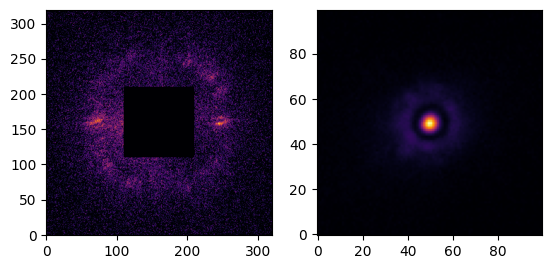

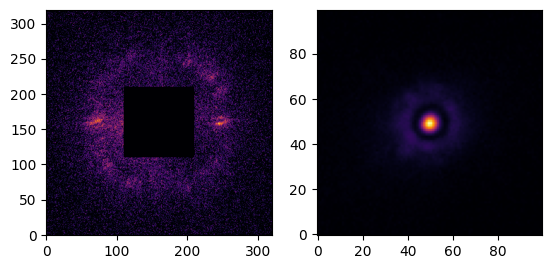

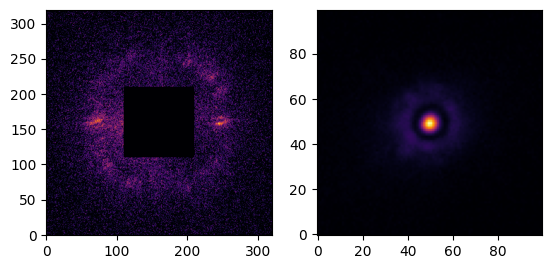

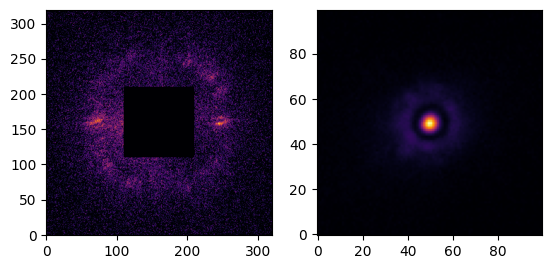

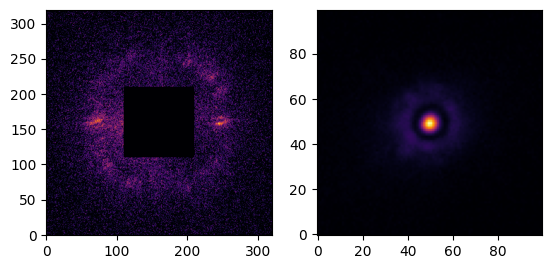

In [19]:
# x_all[0]
# y_all[0]
for i in range(0, 100, 20):
    fig, axs = plt.subplots(1, 2)
    # pai.PlotLinearImg(x_all[0])
    pai.SubplotImg(axs[0], x_all[i])
    pai.SubplotImg(axs[1], y_all[i].reshape(100, 100))


In [20]:
print(x_all.shape, y_all.shape)

(922, 320, 320) (922, 10000)


In [21]:
n_example = y_all.shape[0]
shuffle_index = np.arange(n_example)
np.random.shuffle(shuffle_index)
train_ratio = 0.85
x_train = x_all[shuffle_index[:int(np.ceil(n_example*train_ratio))]]
y_train = y_all[shuffle_index[:int(np.ceil(n_example*train_ratio))]]
x_test = x_all[shuffle_index[int(np.ceil(n_example*train_ratio)):]]
y_test = y_all[shuffle_index[int(np.ceil(n_example*train_ratio)):]]
# shuffle_index
# y_all.shape
# x_all.shape
print(x_train.shape, '\n', y_train.shape, n_example)

(784, 320, 320) 
 (784, 10000) 922


In [22]:
model = tf.keras.models.Sequential([
  # first conv layer
  tf.keras.layers.Conv2D(3, (3, 3), activation="relu", input_shape=(320, 320, 1), strides=2),
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  # second conv layer
  tf.keras.layers.Conv2D(16, (3, 3), activation="relu"),
  tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  # # third conv layer
  # tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
  # tf.keras.layers.MaxPooling2D((2, 2), strides=2),
  tf.keras.layers.Flatten(),
  # hidden layer and output layer
  # tf.keras.layers.Dense(20000, activation='relu'),
  # tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10000)
])
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.MeanSquaredError()
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [14]:
dense_layer = model.layers[-2]
dense_kernel = dense_layer.kernel.numpy()
dense_kernel.shape

AttributeError: 'Flatten' object has no attribute 'kernel'

In [15]:
predictions = model(x_train[:1]).numpy()
print(predictions)
print(y_train[:1])
print(tf.nn.softmax(predictions).numpy())
print(loss_fn(y_train[:1], predictions).numpy())

[[ 0.00612542 -0.0078686  -0.00673442 ...  0.01029774  0.00256554
   0.00626329]]
[[0.02643998 0.04142489 0.02727007 ... 0.01641263 0.02974983 0.02373345]]
[[1.00605350e-04 9.92072892e-05 9.93198701e-05 ... 1.01025980e-04
  1.00247853e-04 1.00619225e-04]]
0.038488552


In [16]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
25/25 [==============================] - 1s 16ms/step - loss: 0.0060 - accuracy: 0.2130
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0038 - accuracy: 0.2679
Epoch 3/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0030 - accuracy: 0.2679
Epoch 4/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0025 - accuracy: 0.2679
Epoch 5/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0022 - accuracy: 0.2730
Epoch 6/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0019 - accuracy: 0.2691
Epoch 7/20
25/25 [==============================] - 0s 15ms/step - loss: 0.0017 - accuracy: 0.2679
Epoch 8/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0018 - accuracy: 0.2691
Epoch 9/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0023 - accuracy: 0.2589
Epoch 10/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0016 - accuracy: 0.2691
Epoch 11/

In [17]:
model.evaluate(x_test,  y_test, verbose=2)

5/5 - 0s - loss: 0.0017 - accuracy: 0.2536 - 140ms/epoch - 28ms/step


[0.0016916763270273805, 0.25362318754196167]

In [45]:
kernels = conv_layer.kernel.numpy()
pai.PlotConv2dKernels(kernels, 5)

ValueError: cannot reshape array of size 15 into shape (3,3)

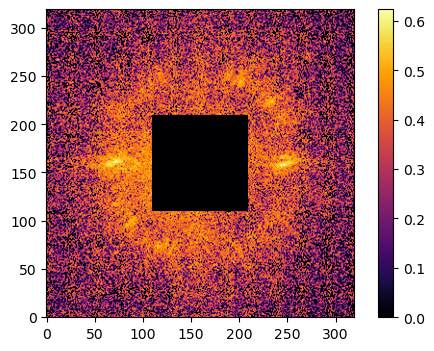

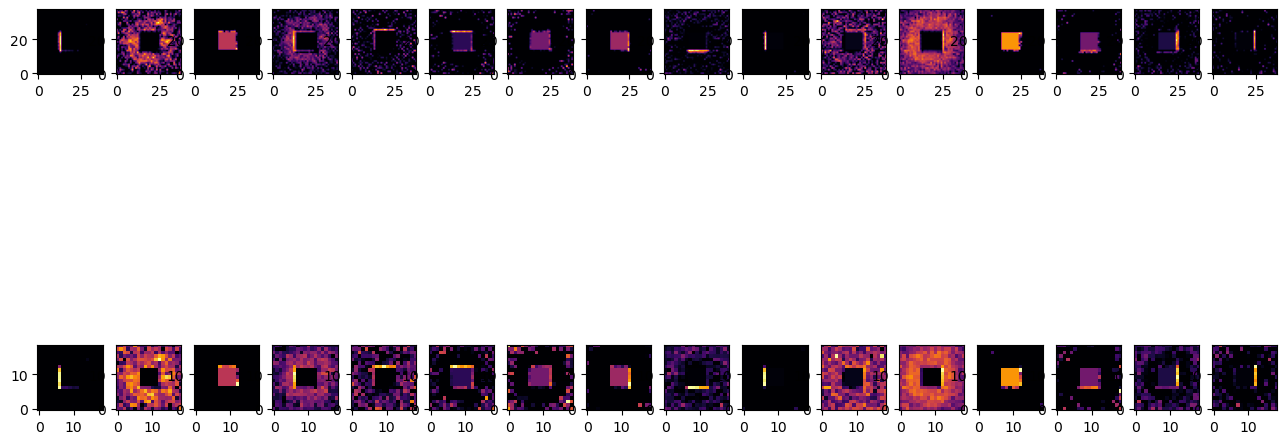

In [56]:
i = 5
conv_layer_1 = model.layers[0]
maxpool_layer_1 = model.layers[1]
conv_layer_2 = model.layers[2]
maxpool_layer_2 = model.layers[3]
fig = plt.figure(figsize = (6, 4))
pai.PlotLinearImg(x_test[i])
x = x_test[i].reshape(-1, 320, 320, 1)
x_conv = conv_layer_1(x)
x_maxpool = maxpool_layer_1(x_conv)
x_conv = conv_layer_2(x_maxpool)
x_maxpool = maxpool_layer_2(x_conv)
kernel_size = (x_conv.shape)[3]
conv_imgs = x_conv.numpy()
maxpool_imgs = x_maxpool.numpy()
fig, axs = plt.subplots(2, kernel_size, figsize=(16, 8))
for k in range(kernel_size):
    # fig = plt.figure(figsize = (6, 4))
    pai.SubplotImg(axs[0, k], conv_imgs[0, :, :, k])
    pai.SubplotImg(axs[1, k], maxpool_imgs[0, :, :, k])

In [20]:
flatten_layer = model.layers[2]

x_after_conv = (1, 98, 98, 3)
x_after_maxpool = (1, 49, 49, 3)
x_after_flatten = (1, 7203)
x_after_dense = (1, 4)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)


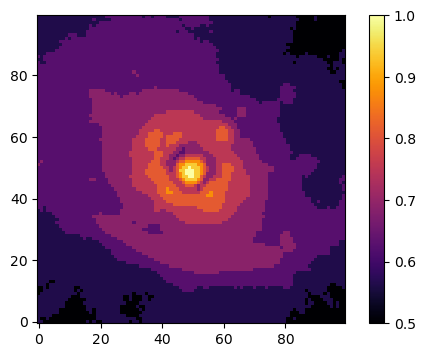

In [31]:
i = 5
fig = plt.figure(figsize = (6, 4))
pai.PlotLinearImg(x_test[i])
x = x_test[i].reshape(-1, 100, 100, 1)
x_conv = conv_layer(x)
print('x_after_conv =', x_conv.shape)
x_conv = maxpool_layer(x_conv)
print('x_after_maxpool =', x_conv.shape)
x_conv = flatten_layer(x_conv)
print('x_after_flatten =', x_conv.shape)
x_conv = dense_layer(x_conv)
print('x_after_dense =', x_conv.shape)
print(x_conv)

In [22]:
# Check all positive example x_conv
for i, label in enumerate(np.argmax(prediction.numpy(), axis=1)):
    if label == 1:
        # fig = plt.figure(figsize = (6, 4))
        # pai.PlotLinearImg(x_test[i])
        x = x_test[i].reshape(-1, 100, 100, 1)
        x_conv = conv_layer(x)
        x_conv = maxpool_layer(x_conv)
        x_conv = flatten_layer(x_conv)
        x_conv = dense_layer(x_conv)
        print(x_conv)

tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=float32)
tf.Tensor([[0. 0. 0. 0.]], shape=(1, 4), dtype=f

In [23]:
# Check all negative example x_conv
for i, label in enumerate(np.argmax(prediction.numpy(), axis=1)):
    if label == 0:
        # fig = plt.figure(figsize = (6, 4))
        # pai.PlotLinearImg(x_test[i])
        x = x_test[i].reshape(-1, 100, 100, 1)
        x_conv = conv_layer(x)
        x_conv = maxpool_layer(x_conv)
        x_conv = flatten_layer(x_conv)
        x_conv = dense_layer(x_conv)
        print(x_conv)

tf.Tensor([[0.        0.        3.3008072 0.       ]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.        0.        1.3600855 0.       ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       10.478509  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.       0.      17.18616  0.     ]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.       0.       8.832752 0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       14.605594  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       10.226739  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       18.028976  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       27.985085  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[0.        0.        6.2010283 0.       ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       21.974054  0.      ]], shape=(1, 4), dtype=float32)
tf.Tensor([[ 0.        0.       12.687721  0.      ]], shape=(1, 4), dtype=float32)


In [24]:
reg_layer = model.layers[4]
reg_kernel = reg_layer.kernel.numpy()
print(reg_kernel)

[[ 0.852273   -0.3781476 ]
 [ 0.5058415   0.80687165]
 [-0.0251086  -0.60841227]
 [ 0.20539618  0.89676595]]


In [25]:
x_conv = reg_layer(x_conv)
x_conv

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.49676722, -3.431046  ]], dtype=float32)>

# Inspect Dense Layer

In [33]:
d1 = dense_kernel[:, 0]

In [52]:
# d1.size
# d1 = d1.reshape(49, 49, 3)
# k = d1[:, :, 0]
# k.shape
dense_kernel.shape[-1]

4

In [42]:
d1.shape[-1]

3

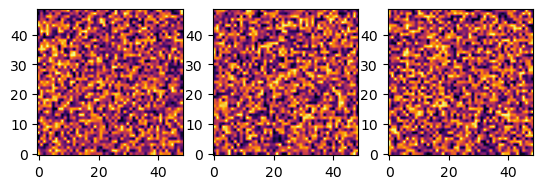

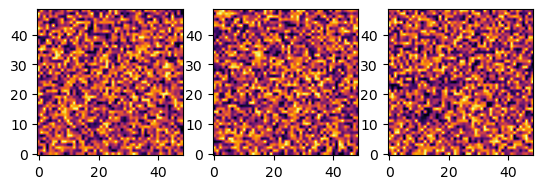

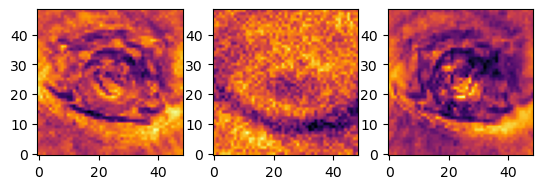

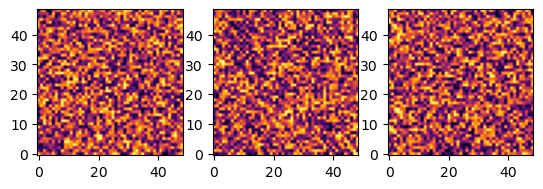

In [54]:
for j in range(dense_kernel.shape[-1]):
    fig, axs = plt.subplots(1, d1.shape[-1])
    d = dense_kernel[:, j]
    d = d.reshape(49, 49, 3)
    for i in range(d1.shape[-1]):
        pai.SubplotImg(axs[i], d[:, :, i])
